# Wildfire Detection

### Importing Libraries

In [6]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

### Preparing Data

In [7]:
train_dir = r'E:\Programs\TSEC\TSEC-HACKS---artemis\mlserver\wildfire_detection\analysis\kaggle\detection\Training and Validation'
test_dir = r'E:\Programs\TSEC\TSEC-HACKS---artemis\mlserver\wildfire_detection\analysis\kaggle\detection\Testing'

In [8]:
# ImageDataGenerator for original images (no augmentation)
original_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for augmented images
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
batch_size = 32
img_height, img_width = 224, 224  # ResNet50V2 expects 224x224 images

In [10]:
# Original images generator
original_train_generator = original_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Augmented images generator
augmented_train_generator = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

Found 1832 images belonging to 2 classes.


Found 1832 images belonging to 2 classes.


In [11]:
# Function to create a tf.data.Dataset from ImageDataGenerator
def create_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, img_height, img_width, 3], [None])
    )
    dataset = dataset.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

original_dataset = create_dataset(original_train_generator)
augmented_dataset = create_dataset(augmented_train_generator)

combined_train_dataset = original_dataset.concatenate(augmented_dataset)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [12]:
# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_dataset = create_dataset(test_generator)

Found 68 images belonging to 2 classes.


### Data Viz

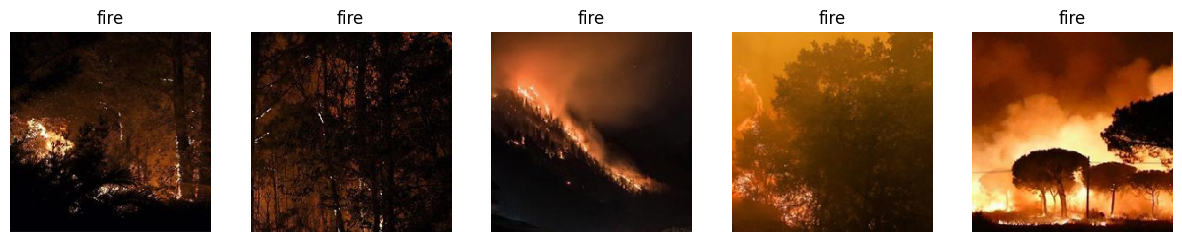

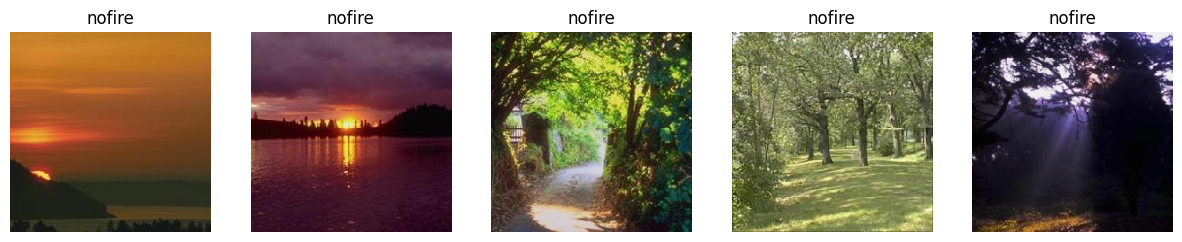

In [13]:
def plot_images(directory, category, num_images):
    category_dir = os.path.join(directory, category)
    images = os.listdir(category_dir)[:num_images]
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_dir, img_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Plotting 5 fire and 5 nofire images
plot_images(train_dir, 'fire', 5)
plot_images(train_dir, 'nofire', 5)


### Model Training

In [14]:
# Load the pre-trained ResNet50V2 model
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False

# Create the model
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,098,817 (91.93 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 23,569,408 (89.91 MB)

In [15]:
# Calculate steps_per_epoch and validation_steps
train_samples = original_train_generator.samples + augmented_train_generator.samples
test_samples = test_generator.samples

steps_per_epoch = train_samples // batch_size
validation_steps = test_samples // batch_size

In [16]:
# Initial training
epochs = 10
history = model.fit(
    combined_train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps
)

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9067 - loss: 0.2186 - val_accuracy: 0.9688 - val_loss: 0.0468
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9832 - loss: 0.0469 - val_accuracy: 0.9688 - val_loss: 0.0559
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.9909 - loss: 0.0289 - val_accuracy: 0.9844 - val_loss: 0.0265
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.9903 - loss: 0.0300 - val_accuracy: 0.9844 - val_loss: 0.0318
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9953 - loss: 0.0165 - val_accuracy: 0.9844 - val_loss: 0.0214
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.9896 - loss: 0.0292 - val_accuracy: 1.0000 - val_loss: 0.0116
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9901 - loss: 0.0247 - val_accuracy: 0.9844 - val_loss: 0.0296
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.9919 - loss: 0.0300 - val_accu

### Model Evaluation

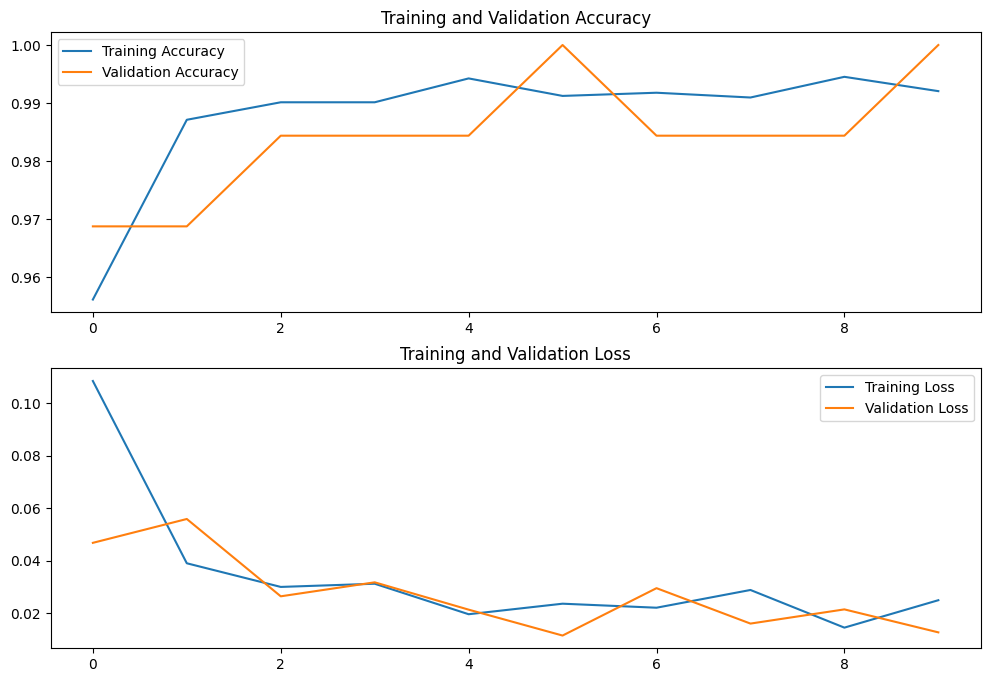

In [17]:
# Function to plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))
    
    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


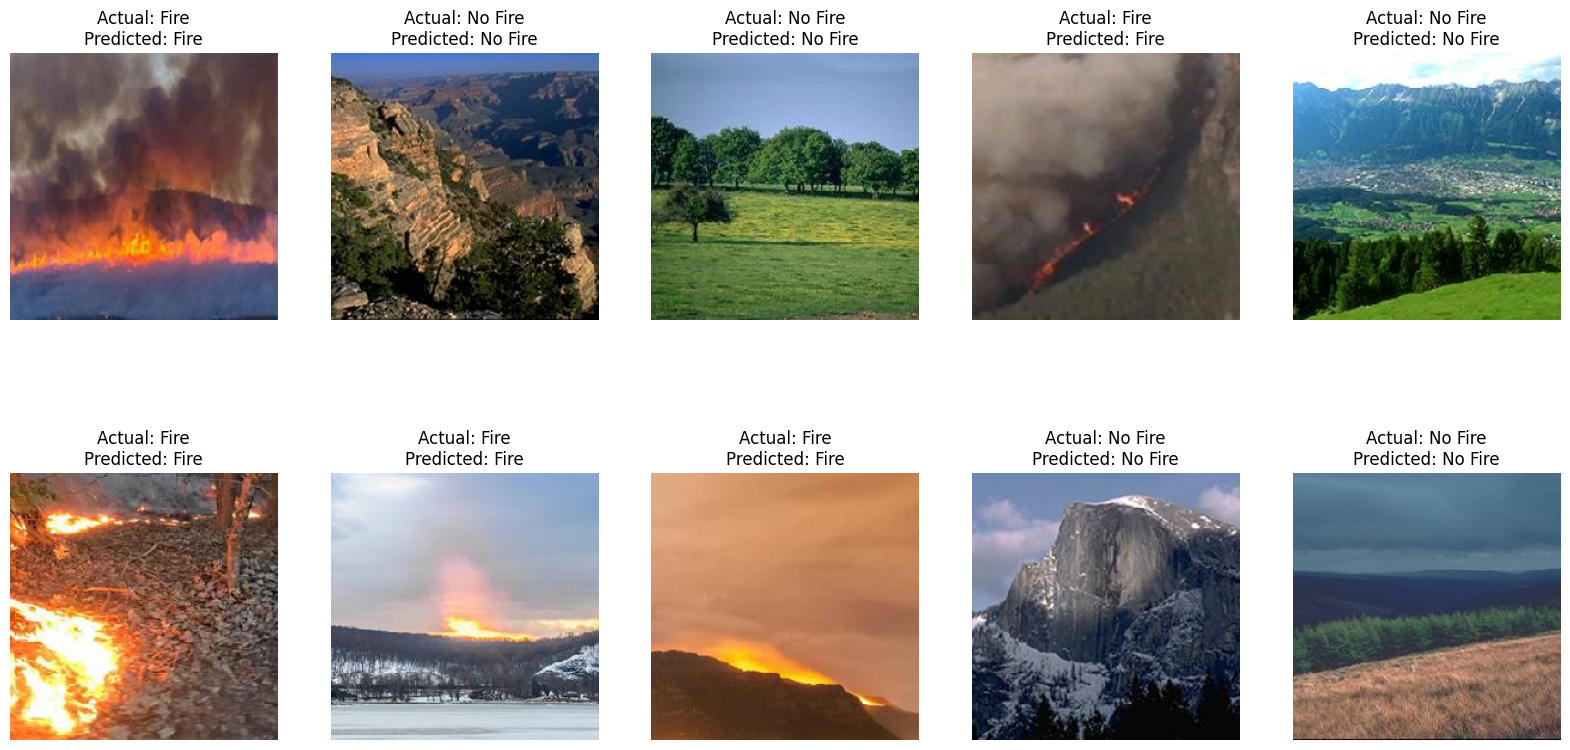

In [18]:
while True:
    try:
        test_images, test_labels = next(test_generator)
        predictions = model.predict(test_images)

        fire_indices = np.where(test_labels == 1)[0]
        nofire_indices = np.where(test_labels == 0)[0]

        random_fire_indices = np.random.choice(fire_indices, 5, replace=False)
        random_nofire_indices = np.random.choice(nofire_indices, 5, replace=False)

        random_indices = np.concatenate((random_fire_indices, random_nofire_indices))
        np.random.shuffle(random_indices)

        # Plot the images with predictions
        plt.figure(figsize=(20, 10))
        for i, idx in enumerate(random_indices):
            plt.subplot(2, 5, i+1)
            plt.imshow(test_images[idx])
            plt.title(f"Actual: {'No Fire' if test_labels[idx] == 1 else 'Fire'}\nPredicted: {'No Fire' if predictions[idx] >= 0.5 else 'Fire'}")
            plt.axis('off')

        plt.show()
        break
        
    except ValueError:
        pass

> **NOTE:** Due to alphabetical order "Fire" is labelled as "0" and "No Fire" is labelled as "1"

In [19]:
# Save the trained model
model.save('wildfire_detection_model.keras')